# Properties and Descriptors in RDKit

Goals: 

* Set properties, generate descriptors
* Understand challenges of working with real geometries and bond orders
* Visualize and export generated molecular data for use in applications, research and reporting

blurb

#### Import the necessary modules and create our molecule set

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# Add atom indices to images to verify descriptor accuracy
IPythonConsole.drawOptions.addAtomIndices = True

# Create a list of Mol objects
amino_acid_supplier = Chem.SDMolSupplier('amino_acids-extended.sdf', sanitize=False, removeHs=False, strictParsing=False)

# Set flags for a limited sanitization (full sanitization results in bad aromaticity detection).
s_flags = Chem.rdmolops.SanitizeFlags.SANITIZE_CLEANUP|Chem.rdmolops.SanitizeFlags.SANITIZE_FINDRADICALS|Chem.rdmolops.SanitizeFlags.SANITIZE_CLEANUPCHIRALITY|Chem.rdmolops.SanitizeFlags.SANITIZE_PROPERTIES|Chem.rdmolops.SanitizeFlags.SANITIZE_ADJUSTHS|Chem.rdmolops.SanitizeFlags.SANITIZE_SETHYBRIDIZATION

# Make a list of the molecule names, instantiated Mol objects and sanitize using the flags set
mol_list = []
amino_acids = []
for mol in amino_acid_supplier:
    mol_name = mol.GetProp('_Name')
    mol_list += [mol_name]
    mol = Chem.Mol(mol)    # See "Creating, Visualizing, ..." for why this is necessary
    amino_acids += [mol]
    Chem.SanitizeMol(mol, sanitizeOps=s_flags, catchErrors=True)

Let's see our molecule set:

['3-methyl-His', '4-hydroxy-Pro', '5-hydroxy-Lys', 'Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His-pi', 'His-tau', 'Ile', 'Leu', 'Lys', 'Met', 'N-methyl-Lys', 'Phe', 'Pro', 'pyroGlu', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']


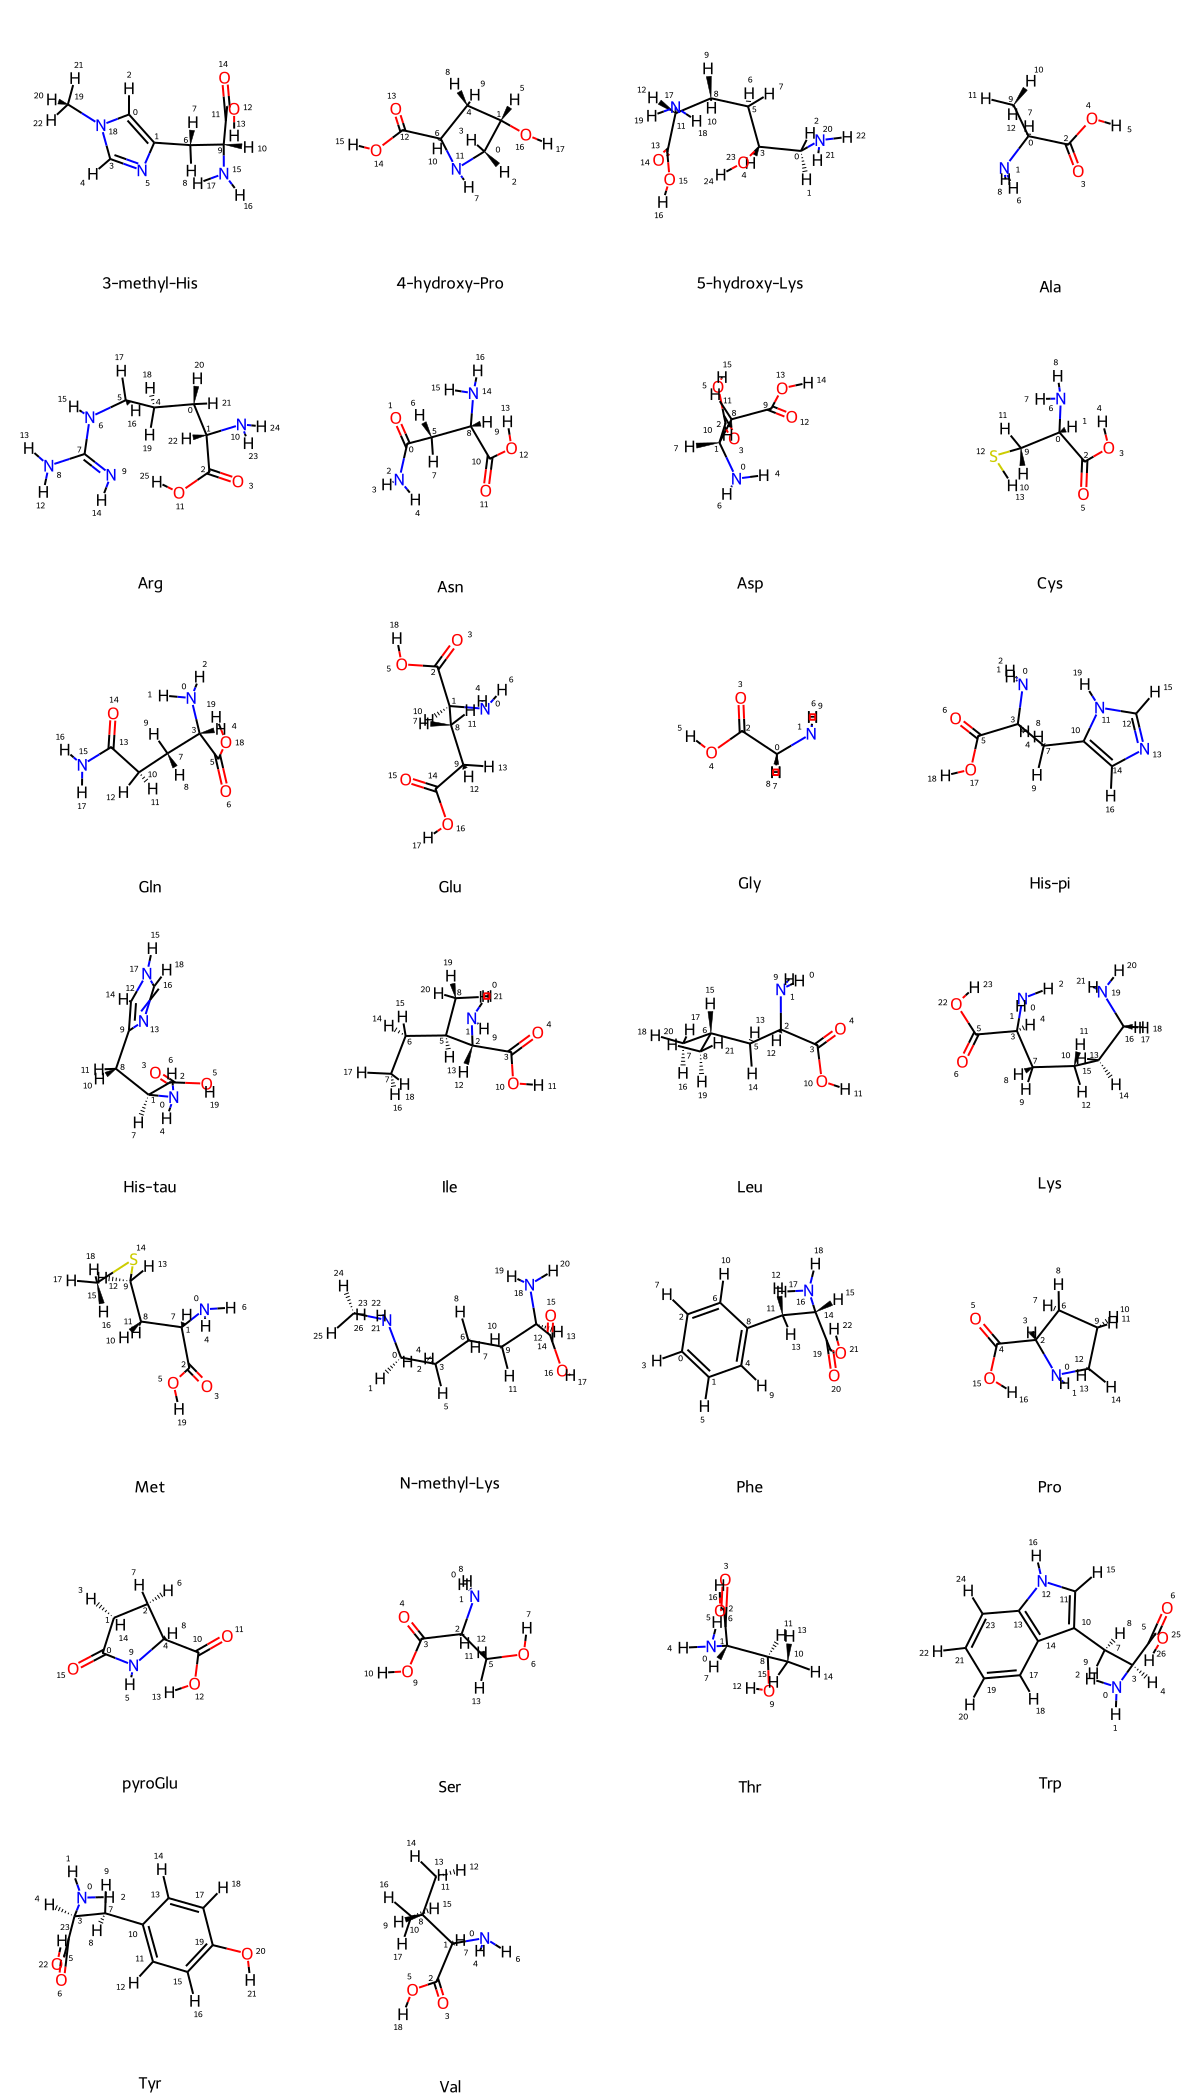

In [2]:
print(mol_list)
Draw.MolsToGridImage(amino_acids, molsPerRow=4, subImgSize=(300,300), legends=mol_list)

## Stereochemistry

RDKit will automatically detect and assign stereocenters from MOL or SDF files, but won't if the molecule is built from a dictionary/JSON block.

### Chiral centers

The process for finding chiral centers (R/S stereocenters) is fairly straightforward:

In [3]:
for index, mol in enumerate(mol_list):
    stereocenter = Chem.FindMolChiralCenters(amino_acids[index])
    print(f"{mol}: {stereocenter}")

3-methyl-His: [(9, 'R')]
4-hydroxy-Pro: [(1, 'S'), (6, 'R')]
5-hydroxy-Lys: [(3, 'R'), (11, 'R')]
Ala: [(0, 'S')]
Arg: [(1, 'S')]
Asn: [(8, 'S')]
Asp: [(1, 'S')]
Cys: [(0, 'R')]
Gln: [(3, 'S')]
Glu: [(1, 'S')]
Gly: []
His-pi: [(3, 'S')]
His-tau: [(1, 'S')]
Ile: [(2, 'S'), (5, 'R')]
Leu: [(2, 'S')]
Lys: [(3, 'S')]
Met: [(1, 'S')]
N-methyl-Lys: [(12, 'R')]
Phe: [(14, 'S')]
Pro: [(2, 'S')]
pyroGlu: [(4, 'R')]
Ser: [(2, 'S')]
Thr: [(1, 'S'), (8, 'R')]
Trp: [(3, 'S')]
Tyr: [(3, 'S')]
Val: [(1, 'S')]


Let's try that with a dictionary-built mol.  To simplify the process a small python module has been created called **dict2mol.py**.  For detailed instructions on building a Mol object from a python dictionary, see the chapter on 'Creating, Visualizing and Saving Mol Objects with RDKit in Python'.

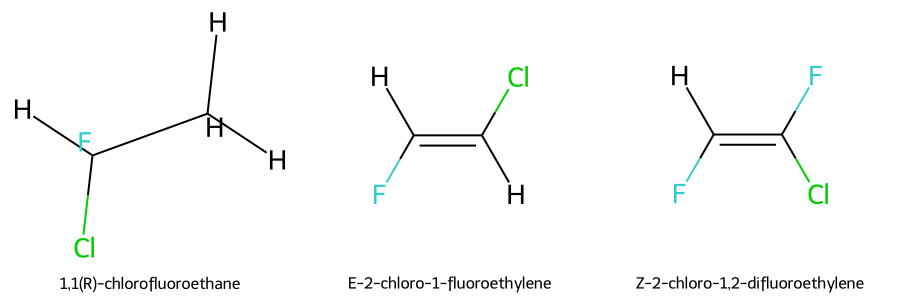

In [4]:
from dict2mol import Dict2Mol    # the module has a single class which builds the Mol

stereomolecules = {    # define the molecules
    "1,1(R)-chlorofluoroethane": {
        "symbols": [
            "C", "C", "H", "Cl", "F", "H", "H", "H"
        ],
        "geometry": [
            [+1.54034068369141, -1.01730823913235, +0.93128102073425],
            [+4.07197633001232, -0.09756825926424, -0.02203578938791],
            [+0.00025636057017, +0.00139534039687, +0.00111211603233],
            [+1.30983130616505, -3.03614919350581, +0.54918567185649],
            [+1.38003941036405, -0.71812565437083, +2.97078783593882],
            [+5.61209917480096, -1.11612498901607, +0.90799157528946],
            [+4.30241880148479, +1.92102238874847, +0.36057345099335],
            [+4.23222331256867, -0.39619160402976, -2.06158817835790],
        ],
        "connectivity": [
            [0, 1, 1], 
            [0, 2, 1], 
            [0, 3, 1], 
            [0, 4, 1], 
            [1, 5, 1], 
            [1, 6, 1], 
            [1, 7, 1]
        ],
    },
    "E-2-chloro-1-fluoroethylene": {
        "symbols": [
            'F', 'C', 'C', 'Cl', 'H', 'H'
        ],
        "geometry": [
            [-0.7500, -1.2990, 0.0000],
            [0.0000, 0.0000, 0.0000],
            [1.5000, 0.0000, 0.0000],
            [2.2500, 1.2990, 0.0000],
            [-0.7500, 1.2990, 0.0000],
            [2.2500, -1.2990, 0.0000],
        ],
        "connectivity": [
            [0, 1, 1],
            [1, 2, 2],
            [1, 4, 1],
            [2, 3, 1],
            [2, 5, 1],
        ],
    },
    "Z-2-chloro-1,2-difluoroethylene": {
        "symbols": [
            'F', 'C', 'C', 'F', 'Cl', 'H'
        ],
        "geometry": [
            [-0.7500, -1.2990, 0.0000],
            [0.0000, 0.0000, 0.0000],
            [1.5000, 0.0000, 0.0000],
            [2.2500, 1.2990, 0.0000],
            [2.2500, -1.2990, 0.0000],
            [-0.7500, 1.2990, 0.0000],
        ],
        "connectivity": [
            [0, 1, 1],
            [1, 2, 2],
            [1, 5, 1],
            [2, 3, 1],
            [2, 4, 1],
        ],
    },
}

builder = Dict2Mol(**stereomolecules)    # the builder makes a list of mol objects from the dictionary

clf_ethane = builder.mol_list[0]
e_clf_ethene = builder.mol_list[1]
z_clf_ethene = builder.mol_list[2]
stereomols = [clf_ethane, e_clf_ethene, z_clf_ethene]

IPythonConsole.drawOptions.addAtomIndices = False

Draw.MolsToGridImage(stereomols,molsPerRow=3,subImgSize=(300,300), legends=builder.names)

Carbon 1 of 1,1(R)-chlorofluoroethane is clearly a chiral center, but RDKit cannot tell.

In [5]:
print(
    Chem.FindMolChiralCenters(clf_ethane), 
    Chem.FindMolChiralCenters(e_clf_ethene), 
    Chem.FindMolChiralCenters(z_clf_ethene)
)

[] [] []


The stereochemistry must be detected from the 3D coordinates:

In [6]:
for mol in stereomols:
    Chem.AssignStereochemistryFrom3D(mol)

print(
    Chem.FindMolChiralCenters(clf_ethane), 
    Chem.FindMolChiralCenters(e_clf_ethene), 
    Chem.FindMolChiralCenters(z_clf_ethene)
)

[(0, 'R')] [] []


### *cis/trans* Stereochemistry

As can be seen however, E/Z stereochemistry is not detected with this method.  This is because **FindMolChiralCenters** only returns atoms with an internal chirality label.  Assigning the stereochemistry from the 3D structure did determine the *cis/trans* conformation of each double bond, however this is stored as a property of the bond, not the associated atoms.

If we want the *cis/trans* conformations of a molecule returned similarly to the stereocenters, we need to loop through the bonds and look for them, then get the atom indices, package these up in a tuple, and set a new property.  The following is a function designed to do just that:

In [7]:
def get_doublebond_stereo(mol):
    stereobonds = []
    for bond in mol.GetBonds():    # loop through the bonds
        is_stereo = False
        stereo = bond.GetStereo()    # get stereochemistry information from them
        # assign a label based on the BondStereo type
        if stereo == Chem.BondStereo.STEREOZ or stereo == Chem.BondStereo.STEREOCIS:
            is_stereo = True
            s_label = 'Z'
        elif stereo == Chem.BondStereo.STEREOE or stereo == Chem.BondStereo.STEREOTRANS:
            is_stereo = True
            s_label = 'E'
        else:    # skip over bonds without e/z stereochemistry
            is_stereo = False
        if is_stereo:
            # get the atom indices
            idx1 = bond.GetBeginAtomIdx()
            idx2 = bond.GetEndAtomIdx()
            stereobonds += [(idx1, idx2, s_label)]    # add the bonds to the list
    if stereobonds != []:    # set a new property if not empty
        mol.SetProp("double-bond stereo", str(stereobonds))
    else:
        stereobonds = None
    
    return stereobonds

Now we can see the stereochemistry:

In [8]:
print(f"\
{e_clf_ethene.GetProp('_Name')}: {get_doublebond_stereo(e_clf_ethene)},\n\
{z_clf_ethene.GetProp('_Name')}: {get_doublebond_stereo(z_clf_ethene)}\
")

E-2-chloro-1-fluoroethylene: [(1, 2, 'E')],
Z-2-chloro-1,2-difluoroethylene: [(1, 2, 'Z')]


#### Putting it all together

Now let's list the complete stereochemistry of our amino acids:

In [9]:
for index, name in enumerate(mol_list):
    stereochem = []
    mol = amino_acids[index]
    chiral = Chem.FindMolChiralCenters(mol)
    db_stereo = get_doublebond_stereo(mol)
    
    if db_stereo is not None:    # python will return an error if a List and None are concatenated
        stereochem = chiral + db_stereo
    else:
        stereochem = chiral

    if stereochem == []:
        stereochem = None    # for readability
    
    mol.SetProp("stereochemistry", str(stereochem))
        
    print(f"{name}: {stereochem}")

3-methyl-His: [(9, 'R')]
4-hydroxy-Pro: [(1, 'S'), (6, 'R')]
5-hydroxy-Lys: [(3, 'R'), (11, 'R')]
Ala: [(0, 'S')]
Arg: [(1, 'S'), (7, 9, 'E')]
Asn: [(8, 'S')]
Asp: [(1, 'S')]
Cys: [(0, 'R')]
Gln: [(3, 'S')]
Glu: [(1, 'S')]
Gly: None
His-pi: [(3, 'S')]
His-tau: [(1, 'S')]
Ile: [(2, 'S'), (5, 'R')]
Leu: [(2, 'S')]
Lys: [(3, 'S')]
Met: [(1, 'S')]
N-methyl-Lys: [(12, 'R')]
Phe: [(14, 'S')]
Pro: [(2, 'S')]
pyroGlu: [(4, 'R')]
Ser: [(2, 'S')]
Thr: [(1, 'S'), (8, 'R')]
Trp: [(3, 'S')]
Tyr: [(3, 'S')]
Val: [(1, 'S')]


## Aromaticity

In [10]:
# Create RDKit(C++) parameters object
parameters = Chem.AdjustQueryParameters()

# Set parameters
parameters.adjustConjugatedFiveRings = True
parameters.aromatizeIfPossible = True
parameters.useStereoCareForBonds = True
parameters.makeAtomsGeneric = False

In [11]:
amino_acids_processed = []
aromaticity = {}
for index, mol in enumerate(mol_list):
    arom_bonds = []
    arom_atoms = []
    
    # First process the molecule according to query parameters
    proc_mol = Chem.AdjustQueryProperties(amino_acids[index], params=parameters)
    # Adjusting properties returns a new Mol object, so put the new object in a list
    amino_acids_processed += [proc_mol]
    
    # Get the bonds and find aromatic ones
    bonds = proc_mol.GetBonds()
    for bond in bonds:
        if bond.GetIsAromatic():
            arom_bonds += [bond.GetIdx()] # add bond index to list
            
            # Adjusting properties doesn't set atom aromaticity, just bonds, so set atoms too.
            atom1 = bond.GetBeginAtom()
            atom1.SetIsAromatic(True)
            atom2 = bond.GetEndAtom()
            atom2.SetIsAromatic(True)

    for atom in proc_mol.GetAromaticAtoms():
        arom_atoms += [atom.GetIdx()]
    
    # Make a dictionary so aromatic atoms or bonds can be returned later
    indices = {"bond_indices": arom_bonds, "atom_indices": arom_atoms}
    
    if indices['bond_indices'] == []:
        indices = None    # for readability
    
    # Create property for aromaticity info
    proc_mol.SetProp("aromaticity", str(indices))
    
    # add mol to full set of aromaticity info
    aromaticity[mol] = indices

for index, mol in enumerate(mol_list):
    print(f"{mol} aromaticity info:\n{aromaticity[mol]}")

3-methyl-His aromaticity info:
{'bond_indices': [0, 2, 3, 6, 7], 'atom_indices': [0, 1, 3, 5, 18]}
4-hydroxy-Pro aromaticity info:
None
5-hydroxy-Lys aromaticity info:
None
Ala aromaticity info:
None
Arg aromaticity info:
None
Asn aromaticity info:
None
Asp aromaticity info:
None
Cys aromaticity info:
None
Gln aromaticity info:
None
Glu aromaticity info:
None
Gly aromaticity info:
None
His-pi aromaticity info:
{'bond_indices': [11, 12, 13, 15, 17], 'atom_indices': [10, 11, 12, 13, 14]}
His-tau aromaticity info:
{'bond_indices': [12, 13, 15, 16, 18], 'atom_indices': [9, 12, 13, 16, 17]}
Ile aromaticity info:
None
Leu aromaticity info:
None
Lys aromaticity info:
None
Met aromaticity info:
None
N-methyl-Lys aromaticity info:
None
Phe aromaticity info:
{'bond_indices': [0, 1, 3, 5, 7, 9], 'atom_indices': [0, 1, 2, 4, 6, 8]}
Pro aromaticity info:
None
pyroGlu aromaticity info:
None
Ser aromaticity info:
None
Thr aromaticity info:
None
Trp aromaticity info:
{'bond_indices': [11, 12, 13, 15, 

In [12]:
for index, mol in enumerate(mol_list):
    print(f"*******\nProperties of {mol}:\n")
    print(f"{amino_acids_processed[index].GetPropsAsDict(includePrivate=True,includeComputed=True)}\n*******\n")


*******
Properties of 3-methyl-His:

{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x7f9cd2053d40>, '_Name': '3-methyl-His', '_MolFileInfo': 'ref: from 2012-Stover_Dixon_ea', '_MolFileComments': '', 'stereochemistry': "[(9, 'R')]", 'numArom': 1, 'aromaticity': "{'bond_indices': [0, 2, 3, 6, 7], 'atom_indices': [0, 1, 3, 5, 18]}"}
*******

*******
Properties of 4-hydroxy-Pro:

{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x7f9cd2053d40>, '_Name': '4-hydroxy-Pro', '_MolFileInfo': 'ref: from 2012-Stover_Dixon_ea', '_MolFileComments': '', 'stereochemistry': "[(1, 'S'), (6, 'R')]", 'numArom': 0, 'aromaticity': 'None'}
*******

*******
Properties of 5-hydroxy-Lys:

{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x7f9cd06283c0>, '_Name': '5-hydroxy-Lys', '_MolFileInfo': 'ref: from 2012-Stover_Dixon_ea', '_MolFileComments': '', 

## Rings

In [13]:
def isRingAromatic(mol, bond_ring):
    for idx in bond_ring:
        if not mol.GetBondWithIdx(idx).GetIsAromatic():
            return False

    return True

def isRingHeterocycle(mol, atom_ring):
    isHeterocycle = False
    for idx in ring:
        atom = mol.GetAtomWithIdx(idx)
        symbol = atom.GetSymbol()
        if symbol == 'C' or isHeterocycle:
            continue
        else:
            isHeterocycle = True
    
    return isHeterocycle

In [14]:
for index, name in enumerate(mol_list):
    mol = amino_acids_processed[index]
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    bond_rings = ring_info.BondRings()
    
    # Get the number of rings
    nrings = len(atom_rings)
    
    if nrings == 0:
        msg = f"{name} has no rings."
    else:
        msg = f"{name} has {nrings} rings.  "
        for index, ring in enumerate(bond_rings):
            isHeterocycle = isRingHeterocycle(mol, atom_rings[index])
            isAromatic = isRingAromatic(mol, ring)
            ring_size = len(atom_rings[index])
            if isHeterocycle:
                if isAromatic:
                    ring_msg = f"Ring {index + 1} is a {ring_size} atom aromatic heterocycle.  "
                else:
                    ring_msg = f"Ring {index + 1} is a {ring_size} atom heterocycle and is not aromatic.  "
            else:    
                if isAromatic:
                    arom_rings += [index]
                    ring_msg = f"Ring {index + 1} has {ring_size} atoms and is aromatic.  "
                else:
                    ring_msg = f"Ring {index + 1} has {ring_size} atoms and is not aromatic.  "
            msg = msg + ring_msg
    print(msg)

3-methyl-His has 1 rings.  Ring 1 is a 5 atom aromatic heterocycle.  
4-hydroxy-Pro has 1 rings.  Ring 1 is a 5 atom heterocycle and is not aromatic.  
5-hydroxy-Lys has no rings.
Ala has no rings.
Arg has no rings.
Asn has no rings.
Asp has no rings.
Cys has no rings.
Gln has no rings.
Glu has no rings.
Gly has no rings.
His-pi has 1 rings.  Ring 1 is a 5 atom aromatic heterocycle.  
His-tau has 1 rings.  Ring 1 is a 5 atom aromatic heterocycle.  
Ile has no rings.
Leu has no rings.
Lys has no rings.
Met has no rings.
N-methyl-Lys has no rings.
Phe has 1 rings.  Ring 1 is a 6 atom aromatic heterocycle.  
Pro has 1 rings.  Ring 1 is a 5 atom heterocycle and is not aromatic.  
pyroGlu has 1 rings.  Ring 1 is a 5 atom heterocycle and is not aromatic.  
Ser has no rings.
Thr has no rings.
Trp has 2 rings.  Ring 1 is a 5 atom aromatic heterocycle.  Ring 2 is a 6 atom aromatic heterocycle.  
Tyr has 1 rings.  Ring 1 is a 6 atom aromatic heterocycle.  
Val has no rings.


## Additional Descriptors

### Atomic Charges

#### Gasteiger atomic charges

Gasteiger, J.; Marseli, M. Iterative Equalization of Oribital Electronegatiity A Rapid Access to Atomic Charges, *Tetrahedron*, **1980**, *36*, p3219.

In [15]:
trp = Chem.Mol(amino_acids_processed[23])

trp.ComputeGasteigerCharges()
g_charges = []

eem_charges = Chem.rdMolDescriptors.CalcEEMcharges(trp)

# Charges are a property of the atoms in the molecule, so they must be iterated through to retrieve
for atom in trp.GetAtoms():
    sym = atom.GetSymbol()
    charge = float(atom.GetProp("_GasteigerCharge"))
    g_charges += [(sym, charge)]

for atom in zip(g_charges, eem_charges):
    print(atom)

(('N', -0.31913265584867284), -0.718941219813577)
(('H', 0.11917723580286499), 0.3161198252863809)
(('H', 0.11917723580286499), 0.3444201767463071)
(('C', 0.09535089161121567), -0.01939162712216246)
(('H', 0.057579012548082696), 0.1849494484487471)
(('C', 0.2755432209656735), 0.47656304188844)
(('O', -0.2649802231932668), -0.6059473538825872)
(('C', -0.0013330134930660206), -0.3085808160186559)
(('H', 0.03382050948159453), 0.2399588812682765)
(('H', 0.03382050948159453), 0.20630791980275345)
(('C', -0.02620951524119318), -0.016432543334590707)
(('C', -0.0144219316836753), -0.06695160218421556)
(('N', -0.2646057783655964), -0.5469853542949165)
(('C', 0.026049160607423124), 0.1791696457728394)
(('C', -0.003093146912979307), -0.02963233017809421)
(('H', 0.07563003718408594), 0.24054628595955774)
(('H', 0.13365304901315941), 0.3342937333264902)
(('C', -0.053066989389726496), -0.21790082642150627)
(('H', 0.06297240273385238), 0.210198953989166)
(('C', -0.061545528415631164), -0.179025486792

### The Descriptors Module

In [16]:
def bcut2D(mol):
    bcut = {
        "bcut2d_chghi": Descriptors.BCUT2D_CHGHI(mol),
        "bcut2d_chglo": Descriptors.BCUT2D_CHGLO(mol),
        "bcut2d_logphi": Descriptors.BCUT2D_LOGPHI(mol),
        "bcut2d_logplow": Descriptors.BCUT2D_LOGPLOW(mol),
        "bcut2d_mrhi": Descriptors.BCUT2D_MRHI(mol),
        "bcut2d_mrlow": Descriptors.BCUT2D_MRLOW(mol),
        "bcut2d_mwhi": Descriptors.BCUT2D_MWHI(mol),
        "bcut2d_mwlow": Descriptors.BCUT2D_MWLOW(mol),
    }
    
    return bcut

def surface_area_approximations(mol):
    peoe_components = {
        "PEOE_VSA1": Descriptors.PEOE_VSA1(mol),
        "PEOE_VSA2": Descriptors.PEOE_VSA2(mol),
        "PEOE_VSA3": Descriptors.PEOE_VSA3(mol),
        "PEOE_VSA4": Descriptors.PEOE_VSA4(mol),
        "PEOE_VSA5": Descriptors.PEOE_VSA5(mol),
        "PEOE_VSA6": Descriptors.PEOE_VSA6(mol),
        "PEOE_VSA7": Descriptors.PEOE_VSA7(mol),
        "PEOE_VSA8": Descriptors.PEOE_VSA8(mol),
        "PEOE_VSA9": Descriptors.PEOE_VSA9(mol),
        "PEOE_VSA10": Descriptors.PEOE_VSA10(mol),
        "PEOE_VSA11": Descriptors.PEOE_VSA11(mol),
        "PEOE_VSA12": Descriptors.PEOE_VSA12(mol),
        "PEOE_VSA13": Descriptors.PEOE_VSA13(mol),
        "PEOE_VSA14": Descriptors.PEOE_VSA14(mol),
    }
    peoe_tot_vsa = sum(peoe_components.values())
    smr_components = {
        "SMR_VSA1": Descriptors.SMR_VSA1(mol),
        "SMR_VSA2": Descriptors.SMR_VSA2(mol),
        "SMR_VSA3": Descriptors.SMR_VSA3(mol),
        "SMR_VSA4": Descriptors.SMR_VSA4(mol),
        "SMR_VSA5": Descriptors.SMR_VSA5(mol),
        "SMR_VSA6": Descriptors.SMR_VSA6(mol),
        "SMR_VSA7": Descriptors.SMR_VSA7(mol),
        "SMR_VSA8": Descriptors.SMR_VSA8(mol),
        "SMR_VSA9": Descriptors.SMR_VSA9(mol),
        "SMR_VSA10": Descriptors.SMR_VSA10(mol),        
    }
    smr_tot_vsa = sum(smr_components.values())
    slogp_components = {
        "SlogP_VSA1": Descriptors.SlogP_VSA1(mol),
        "SlogP_VSA2": Descriptors.SlogP_VSA2(mol),
        "SlogP_VSA3": Descriptors.SlogP_VSA3(mol),
        "SlogP_VSA4": Descriptors.SlogP_VSA4(mol),
        "SlogP_VSA5": Descriptors.SlogP_VSA5(mol),
        "SlogP_VSA6": Descriptors.SlogP_VSA6(mol),
        "SlogP_VSA7": Descriptors.SlogP_VSA7(mol),
        "SlogP_VSA8": Descriptors.SlogP_VSA8(mol),
        "SlogP_VSA9": Descriptors.SlogP_VSA9(mol),
        "SlogP_VSA10": Descriptors.SlogP_VSA10(mol),
        "SlogP_VSA11": Descriptors.SlogP_VSA11(mol),
        "SlogP_VSA12": Descriptors.SlogP_VSA12(mol),        
    }
    slogp_tot_vsa = sum(slogp_components.values())
    ccg_estate_components = {
        "EState_VSA1": Descriptors.EState_VSA1(mol),
        "EState_VSA2": Descriptors.EState_VSA2(mol),
        "EState_VSA3": Descriptors.EState_VSA3(mol),
        "EState_VSA4": Descriptors.EState_VSA4(mol),
        "EState_VSA5": Descriptors.EState_VSA5(mol),
        "EState_VSA6": Descriptors.EState_VSA6(mol),
        "EState_VSA7": Descriptors.EState_VSA7(mol),
        "EState_VSA8": Descriptors.EState_VSA8(mol),
        "EState_VSA9": Descriptors.EState_VSA9(mol),
        "EState_VSA10": Descriptors.EState_VSA10(mol),
        "EState_VSA11": Descriptors.EState_VSA11(mol),        
    }
    ccg_estate_tot_vsa = sum(ccg_estate_components.values())
    rdk_estate_components = {
        "VSA_EState1": Descriptors.VSA_EState1(mol),
        "VSA_EState2": Descriptors.VSA_EState2(mol),
        "VSA_EState3": Descriptors.VSA_EState3(mol),
        "VSA_EState4": Descriptors.VSA_EState4(mol),
        "VSA_EState5": Descriptors.VSA_EState5(mol),
        "VSA_EState6": Descriptors.VSA_EState6(mol),
        "VSA_EState7": Descriptors.VSA_EState7(mol),
        "VSA_EState8": Descriptors.VSA_EState8(mol),
        "VSA_EState9": Descriptors.VSA_EState9(mol),
        "VSA_EState10": Descriptors.VSA_EState10(mol),        
    }
    rdk_estate_tot_vsa = sum(rdk_estate_components.values())
    vsa_approximations = [peoe_tot_vsa, smr_tot_vsa, slogp_tot_vsa, ccg_estate_tot_vsa, rdk_estate_tot_vsa]
    avg_vsa_approx = sum(vsa_approximations) / len(vsa_approximations)
    surface_areas = {
        "TPSA": Descriptors.TPSA(mol, includeSandP=True),
        "Labute_ASA": Descriptors.LabuteASA(mol),
        "PEOE_VSA": peoe_tot_vsa,
        "SMR_VSA": smr_tot_vsa,
        "SlogP_VSA": slogp_tot_vsa,
        "EState_VSA-CCG": ccg_estate_tot_vsa,
        "EState_VSA-RDK": rdk_estate_tot_vsa,
        "Avg_VSA_approx": avg_vsa_approx,
    }
    
    return surface_areas

def hall_kier_parameters(mol):
    parameters = {
        'alpha': Descriptors.HallKierAlpha(mol),
        'phi': Chem.rdMolDescriptors.CalcPhi(mol),
        'kappa_1': Chem.rdMolDescriptors.CalcKappa1(mol),
        'kappa_2': Chem.rdMolDescriptors.CalcKappa2(mol),
        'kappa_3': Chem.rdMolDescriptors.CalcKappa3(mol),
        'chi_0': Descriptors.Chi0(mol),
        'chi_1': Descriptors.Chi1(mol),
        'chi_0n': Descriptors.Chi0n(mol),
        'chi_1n': Descriptors.Chi1n(mol),
        'chi_2n': Descriptors.Chi2n(mol),
        'chi_3n': Descriptors.Chi3n(mol),
        'chi_4n': Descriptors.Chi4n(mol),
        'chi_0v': Descriptors.Chi0v(mol),
        'chi_1v': Descriptors.Chi1v(mol),
        'chi_2v': Descriptors.Chi2v(mol),
        'chi_3v': Descriptors.Chi3v(mol),
        'chi_4v': Descriptors.Chi4v(mol),
    }
    
    return parameters

def get_inchi(mol):
    inchi_plus = Chem.rdinchi.MolToInchi(mol)
    inchi = inchi_plus[0]
    inchi_key = Chem.rdinchi.InchiToInchiKey(inchi)
    
    return inchi_key, inchi

def counts(mol):
    counts = {
        "valence": Descriptors.NumValenceElectrons(mol),
        "radical_electrons": Descriptors.NumRadicalElectrons(mol),
        "heteroatoms": Descriptors.NumHeteroatoms(mol),
        "n_o": Descriptors.NOCount(mol),
        "nh_oh": Descriptors.NHOHCount(mol),
        "h_acceptors": Descriptors.NumHAcceptors(mol),
        "h_donors": Descriptors.NumHDonors(mol),
        "rotatable_bonds": Descriptors.NumRotatableBonds(mol),
        "aromatic_carbocycles": Descriptors.NumAromaticCarbocycles(mol),
        "aliphatic_carbocycles": Descriptors.NumAliphaticCarbocycles(mol),
        "aromatic_heterocycles": Descriptors.NumAromaticHeterocycles(mol), 
        "aliphatic_heterocycles": Descriptors.NumAliphaticHeterocycles(mol),
        "spiro_atoms": Chem.rdMolDescriptors.CalcNumSpiroAtoms(mol),
        "bridgehead_atoms": Chem.rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
    }
    
    return counts

In [17]:
def basic_descriptors(mol):
    inchi_key, inchi = get_inchi(mol)
    descriptors = {
        "InChI Key": inchi_key,
        "InChI": inchi,
        "Ring/Atom/Electron Counts": counts(mol),
        "Balaban index": Descriptors.BalabanJ(mol),
        "Bertz CT complexity index": Descriptors.BertzCT(mol),
        "Ipc": Descriptors.Ipc(mol),
        "log-P": Descriptors.MolLogP(mol),
        "Molar Refractivity": Descriptors.MolMR(mol),
        "Hall-Kier parameters": hall_kier_parameters(mol),
        "Surface_Area_approximations": surface_area_approximations(mol),
        "Plane of Best Fit": Chem.rdMolDescriptors.CalcPBF(mol),
        "Principal Moments of Inertia": [Descriptors3D.PMI1(mol), Descriptors3D.PMI2(mol), Descriptors3D.PMI3(mol)],
        "Normalized Principal Moments": [Descriptors3D.NPR1(mol), Descriptors3D.NPR2(mol)],
        "Radius of gyration": Descriptors3D.RadiusOfGyration(mol),
        "Inertial shape factor": Descriptors3D.InertialShapeFactor(mol),
        "Eccentricity": Descriptors3D.Eccentricity(mol),
        "Asphericity": Descriptors3D.Asphericity(mol),
        "Spherocity index": Descriptors3D.SpherocityIndex(mol),
        "Autocorr 2D": Chem.rdMolDescriptors.CalcAUTOCORR2D(mol),
        "BCUT 2D": bcut2D(mol),
        "Autocorr 3D": Chem.rdMolDescriptors.CalcAUTOCORR3D(mol),
        "MoRSE": Chem.rdMolDescriptors.CalcMORSE(mol),
        "Radial Distribution Function": Chem.rdMolDescriptors.CalcRDF(mol),
        "WHIM": Chem.rdMolDescriptors.CalcWHIM(mol),
        "GETAWAY": Chem.rdMolDescriptors.CalcGETAWAY(mol),
    }
    
    return descriptors

In [18]:
for index, name in enumerate(mol_list):
    desc = basic_descriptors(amino_acids_processed[index])
    print(f"*******\nBasic Information on {name}:\n{json.dumps(desc, indent=4)}\n*******\n")

*******
Basic Information on 3-methyl-His:
{
    "InChI Key": "BRMWTNUJHUMWMS-ZCFIWIBFSA-N",
    "InChI": "InChI=1S/C7H11N3O2/c1-10-3-5(9-4-10)2-6(8)7(11)12/h3-4,6H,2,8H2,1H3,(H,11,12)/t6-/m1/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 66,
        "radical_electrons": 0,
        "heteroatoms": 5,
        "n_o": 5,
        "nh_oh": 3,
        "h_acceptors": 5,
        "h_donors": 2,
        "rotatable_bonds": 5,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 1,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 3.6432043936351635,
    "Bertz CT complexity index": 611.4966663060883,
    "Ipc": 47833.665915905745,
    "log-P": -0.6255000000000001,
    "Molar Refractivity": 42.523199999999996,
    "Hall-Kier parameters": {
        "alpha": -1.0400000000000003,
        "phi": 0.671267288453533,
        "kappa_1": 2.2545743378422753,
        "kappa_2":

*******
Basic Information on Arg:
{
    "InChI Key": "ODKSFYDXXFIFQN-BYPYZUCNSA-N",
    "InChI": "InChI=1S/C6H14N4O2/c7-4(5(11)12)2-1-3-10-6(8)9/h4H,1-3,7H2,(H,11,12)(H4,8,9,10)/t4-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 70,
        "radical_electrons": 0,
        "heteroatoms": 6,
        "n_o": 6,
        "nh_oh": 7,
        "h_acceptors": 4,
        "h_donors": 5,
        "rotatable_bonds": 6,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 6.4528732153455675,
    "Bertz CT complexity index": 553.5550888277661,
    "Ipc": 118575.4730007525,
    "log-P": -1.338429999999998,
    "Molar Refractivity": 44.762000000000015,
    "Hall-Kier parameters": {
        "alpha": -0.8200000000000001,
        "phi": 0.9549531909965968,
        "kappa_1": 1.9816400295276464,
        "kappa_2": 5.78280

*******
Basic Information on His-pi:
{
    "InChI Key": "HNDVDQJCIGZPNO-YFKPBYRVSA-N",
    "InChI": "InChI=1S/C6H9N3O2/c7-5(6(10)11)1-4-2-8-3-9-4/h2-3,5H,1,7H2,(H,8,9)(H,10,11)/t5-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 60,
        "radical_electrons": 0,
        "heteroatoms": 5,
        "n_o": 5,
        "nh_oh": 4,
        "h_acceptors": 4,
        "h_donors": 3,
        "rotatable_bonds": 4,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 1,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 3.5653775806456967,
    "Bertz CT complexity index": 531.9977156401155,
    "Ipc": 14958.323258151313,
    "log-P": -0.6359000000000004,
    "Molar Refractivity": 37.9029,
    "Hall-Kier parameters": {
        "alpha": -1.04,
        "phi": 0.6834868268861061,
        "kappa_1": 2.2243272979757522,
        "kappa_2": 3.3800579180003054,
        "ka

*******
Basic Information on His-tau:
{
    "InChI Key": "HNDVDQJCIGZPNO-YFKPBYRVSA-N",
    "InChI": "InChI=1S/C6H9N3O2/c7-5(6(10)11)1-4-2-8-3-9-4/h2-3,5H,1,7H2,(H,8,9)(H,10,11)/t5-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 60,
        "radical_electrons": 0,
        "heteroatoms": 5,
        "n_o": 5,
        "nh_oh": 4,
        "h_acceptors": 4,
        "h_donors": 3,
        "rotatable_bonds": 4,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 1,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 3.521018363555765,
    "Bertz CT complexity index": 531.9977156401155,
    "Ipc": 15680.07278708319,
    "log-P": -0.6359000000000004,
    "Molar Refractivity": 37.9029,
    "Hall-Kier parameters": {
        "alpha": -1.04,
        "phi": 0.6834868268861061,
        "kappa_1": 2.2243272979757522,
        "kappa_2": 3.3800579180003054,
        "kap

*******
Basic Information on Ile:
{
    "InChI Key": "AGPKZVBTJJNPAG-UHNVWZDZSA-N",
    "InChI": "InChI=1S/C6H13NO2/c1-3-4(2)5(7)6(8)9/h4-5H,3,7H2,1-2H3,(H,8,9)/t4-,5+/m1/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 54,
        "radical_electrons": 0,
        "heteroatoms": 3,
        "n_o": 3,
        "nh_oh": 3,
        "h_acceptors": 3,
        "h_donors": 2,
        "rotatable_bonds": 6,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 6.794037423163941,
    "Bertz CT complexity index": 429.22670185219465,
    "Ipc": 14441.843868328826,
    "log-P": 0.4443999999999999,
    "Molar Refractivity": 35.066199999999995,
    "Hall-Kier parameters": {
        "alpha": -0.41,
        "phi": 0.46483294781188494,
        "kappa_1": 1.167250375694572,
        "kappa_2": 3.5840609841890827,
        "kappa

*******
Basic Information on Leu:
{
    "InChI Key": "ROHFNLRQFUQHCH-YFKPBYRVSA-N",
    "InChI": "InChI=1S/C6H13NO2/c1-4(2)3-5(7)6(8)9/h4-5H,3,7H2,1-2H3,(H,8,9)/t5-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 54,
        "radical_electrons": 0,
        "heteroatoms": 3,
        "n_o": 3,
        "nh_oh": 3,
        "h_acceptors": 3,
        "h_donors": 2,
        "rotatable_bonds": 6,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 6.64213729585679,
    "Bertz CT complexity index": 413.22670185219454,
    "Ipc": 14296.923070000514,
    "log-P": 0.4443999999999999,
    "Molar Refractivity": 35.066199999999995,
    "Hall-Kier parameters": {
        "alpha": -0.41,
        "phi": 0.46483294781188494,
        "kappa_1": 1.167250375694572,
        "kappa_2": 3.5840609841890827,
        "kappa_3":

*******
Basic Information on N-methyl-Lys:
{
    "InChI Key": "PQNASZJZHFPQLE-ZCFIWIBFSA-N",
    "InChI": "InChI=1S/C7H16N2O2/c1-9-5-3-2-4-6(8)7(10)11/h6,9H,2-5,8H2,1H3,(H,10,11)/t6-/m1/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 66,
        "radical_electrons": 0,
        "heteroatoms": 4,
        "n_o": 4,
        "nh_oh": 4,
        "h_acceptors": 4,
        "h_donors": 3,
        "rotatable_bonds": 8,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 6.626695341039751,
    "Bertz CT complexity index": 559.4622678229741,
    "Ipc": 126579.88868337977,
    "log-P": -0.2120000000000002,
    "Molar Refractivity": 43.3889,
    "Hall-Kier parameters": {
        "alpha": -0.44999999999999996,
        "phi": 0.840456790576096,
        "kappa_1": 1.4739318170503333,
        "kappa_2": 6.27235574223400

*******
Basic Information on Pro:
{
    "InChI Key": "ONIBWKKTOPOVIA-BYPYZUCNSA-N",
    "InChI": "InChI=1S/C5H9NO2/c7-5(8)4-2-1-3-6-4/h4,6H,1-3H2,(H,7,8)/t4-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 46,
        "radical_electrons": 0,
        "heteroatoms": 3,
        "n_o": 3,
        "nh_oh": 2,
        "h_acceptors": 3,
        "h_donors": 2,
        "rotatable_bonds": 1,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 1,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 3.5056615143927123,
    "Bertz CT complexity index": 357.2953760188613,
    "Ipc": 2756.368303152342,
    "log-P": -0.177,
    "Molar Refractivity": 28.660499999999992,
    "Hall-Kier parameters": {
        "alpha": -0.41,
        "phi": 0.33519818784121974,
        "kappa_1": 1.1976221868333936,
        "kappa_2": 2.239091369724937,
        "kappa_3": 1.0501353032284986

*******
Basic Information on Thr:
{
    "InChI Key": "AYFVYJQAPQTCCC-GBXIJSLDSA-N",
    "InChI": "InChI=1S/C4H9NO3/c1-2(6)3(5)4(7)8/h2-3,6H,5H2,1H3,(H,7,8)/t2-,3+/m1/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 48,
        "radical_electrons": 0,
        "heteroatoms": 4,
        "n_o": 4,
        "nh_oh": 4,
        "h_acceptors": 4,
        "h_donors": 3,
        "rotatable_bonds": 5,
        "aromatic_carbocycles": 0,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 0,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 5.835439899276245,
    "Bertz CT complexity index": 294.45577849918374,
    "Ipc": 2278.32118470648,
    "log-P": -1.2209000000000003,
    "Molar Refractivity": 27.29199999999999,
    "Hall-Kier parameters": {
        "alpha": -0.44999999999999996,
        "phi": 0.4621402709958412,
        "kappa_1": 1.3395803393265164,
        "kappa_2": 2.759910741766697,
       

*******
Basic Information on Trp:
{
    "InChI Key": "QIVBCDIJIAJPQS-VIFPVBQESA-N",
    "InChI": "InChI=1S/C11H12N2O2/c12-9(11(14)15)5-7-6-13-10-4-2-1-3-8(7)10/h1-4,6,9,13H,5,12H2,(H,14,15)/t9-/m0/s1",
    "Ring/Atom/Electron Counts": {
        "valence": 78,
        "radical_electrons": 0,
        "heteroatoms": 4,
        "n_o": 4,
        "nh_oh": 4,
        "h_acceptors": 3,
        "h_donors": 3,
        "rotatable_bonds": 4,
        "aromatic_carbocycles": 1,
        "aliphatic_carbocycles": 0,
        "aromatic_heterocycles": 1,
        "aliphatic_heterocycles": 0,
        "spiro_atoms": 0,
        "bridgehead_atoms": 0
    },
    "Balaban index": 3.0603841366697417,
    "Bertz CT complexity index": 941.7955186031381,
    "Ipc": 486674.11172676855,
    "log-P": 1.1222999999999996,
    "Molar Refractivity": 57.613900000000015,
    "Hall-Kier parameters": {
        "alpha": -1.4899999999999998,
        "phi": 0.790197934426489,
        "kappa_1": 3.00850344368032,
        "kappa_2